In [1]:
import rasterio
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os
import glob
from PIL import Image 
import imageio
from keras.utils import to_categorical
from tqdm.notebook import tqdm
import pandas as pd

Using TensorFlow backend.
/home/fortanel/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/fortanel/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/fortanel/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/fortanel/.local/lib/python3.6/site-packages/tensorflo

In [2]:
def getData(X_route, Y_route):
    X_datos = np.empty((0,128,128,7))
    Y_etiquetas = np.empty((0,128,128,1))
    for elemento in tqdm(zip(X_route,Y_route)):
        X_datos = np.append(X_datos,[np.load(elemento[0].replace(".npy", "0.npy"))],axis=0)
        Y_etiquetas = np.append(Y_etiquetas,[np.load(elemento[1].replace(".npy", "0.npy"))],axis=0)   
    X = X_datos.reshape(X_datos.shape[0]*128*128,7)
    Y = Y_etiquetas.reshape(Y_etiquetas.shape[0]*128*128)
    Y[Y>0] = 1
    Y = to_categorical(Y)
    return X,Y

In [3]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.activations import relu, softmax

def make_model():
    model = Sequential()
    model.add(Dense(20, input_dim=7, activation=relu))
    model.add(Dense(20, activation=relu))
    model.add(Dense(20, activation=relu))
    model.add(Dense(2, activation=softmax))
    
    model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])
    
    return model

In [4]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import time

def train_model(training_model,x_train,y_train,x_test,y_test,epochs_train):
    callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model_E01.h5', verbose=1, save_best_only=True, save_weights_only=True)
    ]
    training_model.summary()
    
    start_time = time.time()
    
    history = training_model.fit(x_train, y_train,
                        validation_data = (x_test,y_test), 
                        epochs=epochs_train, 
                        batch_size=64,
                        callbacks = callbacks)
    
    plt.figure(figsize=(8, 8))
    plt.title("Learning curve")
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.plot( np.argmin(history.history["val_loss"]), np.min(history.history["val_loss"]), marker="x", color="r", label="best model")
    plt.xlabel("Epochs")
    plt.ylabel("log_loss")
    plt.legend();
    plt.savefig("Roc_01")

  
    print("--- %s seconds ---" % (time.time() - start_time))
    return training_model

In [5]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix,roc_curve,roc_auc_score,auc
import matplotlib.pyplot as plt

def evaluate(x_test,y_test,model):
    model.load_weights("model_E01.h5")
    
    y_pred = model.predict(X_test)
    y_pred = (y_pred > 0.5).astype(np.uint8)

   # Print f1, precision, and recall scores
    print("precision: "+ str(precision_score(np.argmax(y_pred,axis = 1), np.argmax(y_test,axis = 1))))
    print("recall: " + str(recall_score(np.argmax(y_pred,axis = 1), np.argmax(y_test,axis = 1))))
    print("f1 score: " + str(f1_score(np.argmax(y_pred,axis = 1), np.argmax(y_test,axis = 1))))
    print("confusion matrix")
    print(confusion_matrix(np.argmax(y_pred,axis = 1), np.argmax(y_test,axis = 1)))
    
    #segundo
    
    #y_p =y_pred1.reshape(y_pred1.shape[0]*128*128*1)
    fpr, tpr, thresholds = roc_curve(np.argmax(y_test,axis = 1),np.argmax(y_pred,axis = 1))
    print(auc(fpr, tpr))
    plt.figure(2)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.show()

 

In [6]:
from sklearn.model_selection import train_test_split

datos = next(os.walk("/home/fortanel/Escuela/Tesis/preprocesamiento/cortadas/etiquetas/"))[2]
imagenes = ["/home/fortanel/Escuela/Tesis/preprocesamiento/cortadas/imagenes/" + imagen for imagen in datos]
imagenes = [elemento[:-5] + elemento[-4:] for elemento in imagenes]
imagenes = list(set(imagenes))
imagenes.sort()
etiquetas = [elemento.replace("imagenes","etiquetas") for elemento in imagenes]


X_train,X_test,Y_train,Y_test = train_test_split(imagenes,etiquetas,test_size = 0.1,random_state=42)
X_train, Y_train = getData(X_train,Y_train)
X_test, Y_test = getData(X_test,Y_test)

In [7]:
model_simple = make_model()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 20)                160       
_________________________________________________________________
dense_2 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_3 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 42        
Total params: 1,042
Trainable params: 1,042
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 16678912 samples, validate on 1867776 samples
Epoch 1/15
16678912/16678912 [==============================] - 327s 20us/step - loss: 0.0815 - accu

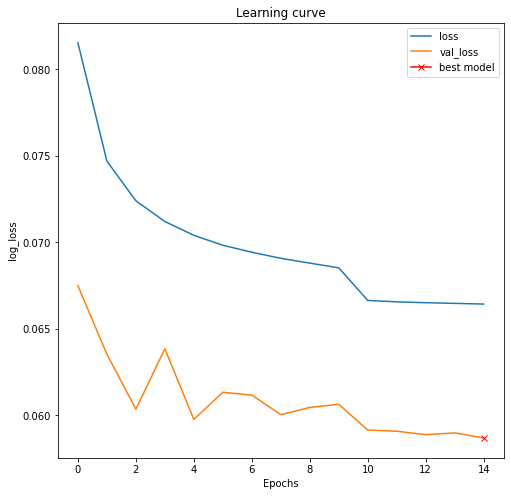

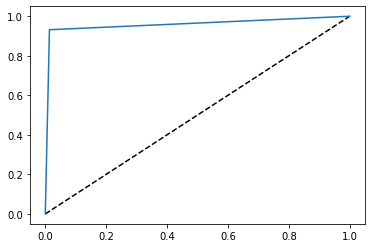

In [8]:
history = train_model(model_simple,X_train,Y_train,X_test,Y_test,15)
evaluate(X_test,Y_test,model_simple)

In [33]:
def IoU(y_true,y_pred):
  
    suma= y_true + y_pred
        
    if len(suma) == 0:
        return 1
    else:
        return len(suma[suma==2])/len(suma[suma>0])

In [23]:
y_pred = model_simple.predict(X_test)
y_pred = (y_pred > 0.5).astype(np.uint8)

In [34]:
#Se calcula el indice de jarccard
IoU(np.argmax(Y_test,axis = 1),np.argmax(y_pred,axis = 1))

0.8732486800140165

/home/fortanel/Escuela/Tesis/Imagenes/CUADROS-8/LC08_033042_2018abr17_stack.tif


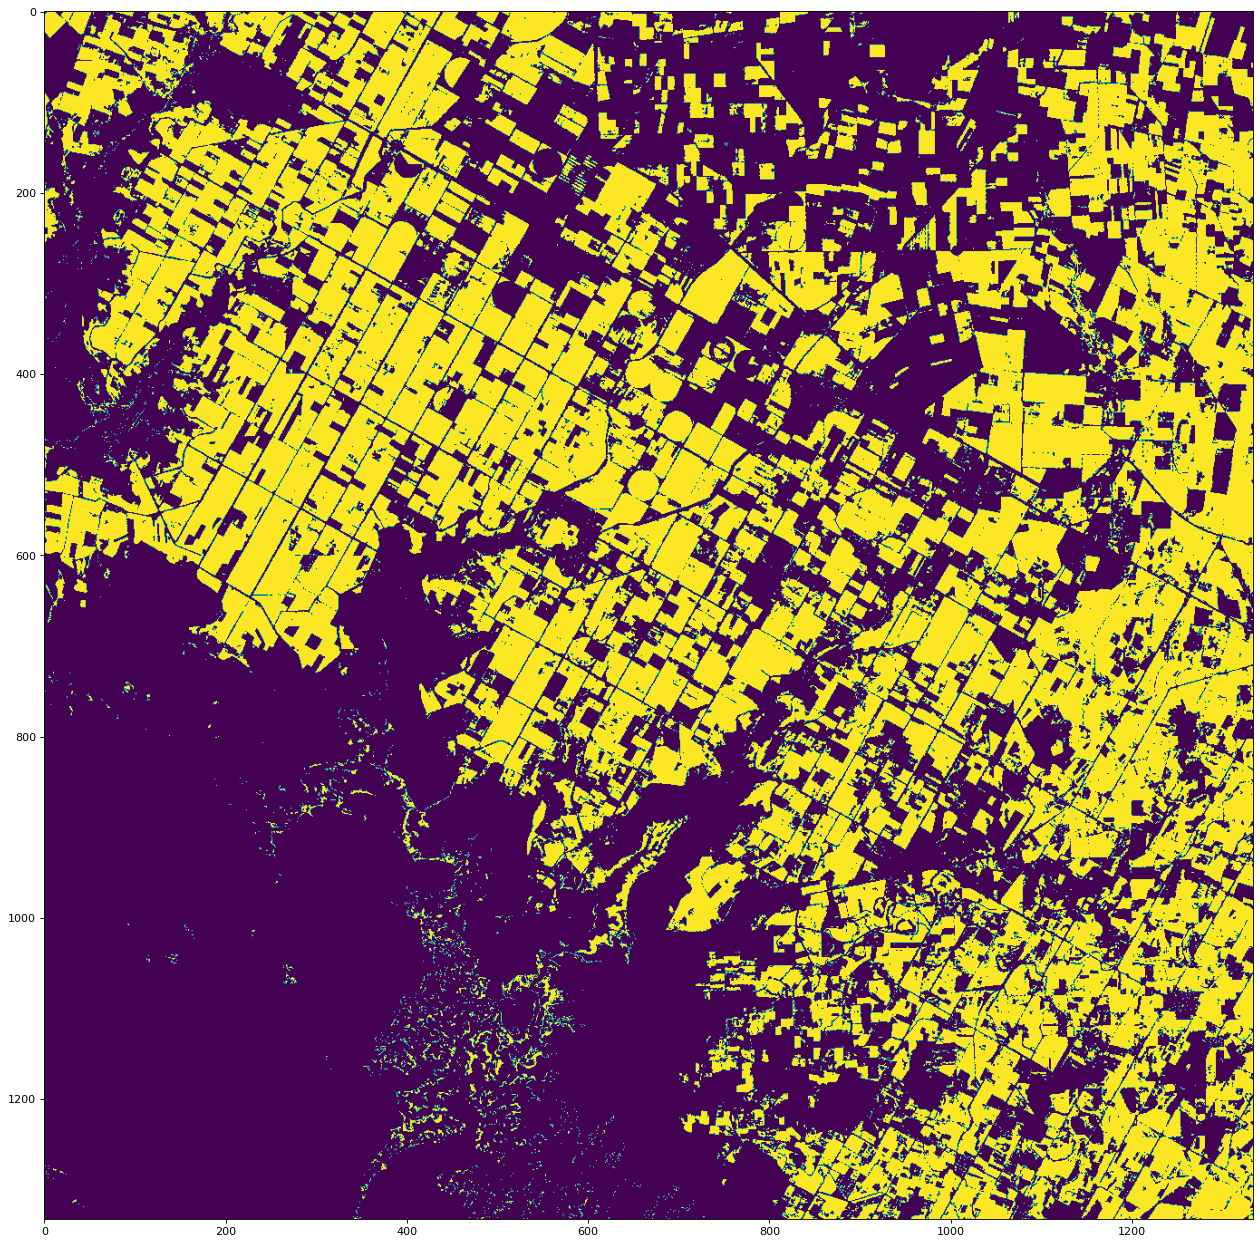

In [10]:
import os
import glob
#imagenes = next(os.walk("/home/fortanel/Escuela/Tesis/Imagenes/wetransfer-c12f06/ImagenesSat/AutlanJalisco2019/"))[2]
#imagenes
data_dir = "/home/fortanel/Escuela/Tesis/Imagenes/"
eti_dir =  "/home/fortanel/Escuela/Tesis/etiquetas/"

files = glob.glob("/home/fortanel/Escuela/Tesis/Imagenes/" + '/**/*.tif', recursive=True)
nombres = [os.path.basename(elemento) for elemento in files]
nombres = [elemento.replace(".tif","") for elemento in nombres]
terminadas = glob.glob("/home/fortanel/Escuela/Tesis/etiquetas/" + '*.png', recursive=True)
terminadas = [os.path.basename(elemento) for elemento in terminadas]
terminadas = [ elemento.replace("_mascara_terminada.png","") for elemento in terminadas]
id1 = 161

fp3 = files[id1]
print(files[id1])
prueba = rasterio.open(fp3)
banda = prueba.read(1)
test = prueba.read(1)
for i in range(2,8):
    datos1 = prueba.read(i)
    test = np.dstack((test,datos1))
test = test.reshape(test.shape[0]*test.shape[1],7)
resultado = model_simple.predict(test)
#resultado = model.predict(test)
pred = list()
for ele in resultado:
    pred.append(np.argmax(ele))

pred = np.array(pred)
pred = pred.reshape((banda.shape[0],banda.shape[1]))
#mascara = np.zeros((banda.shape[0],banda.shape[1]),dtype = np.float32)
#for i in range(0,banda.shape[0]):
    #for j in range(0,banda.shape[1]): 
mascara = pred.reshape((banda.shape[0],banda.shape[1])) 
        
figure(num=None, figsize=(20, 20), dpi=80, facecolor='w', edgecolor='k')
plt.imshow(mascara)